# Bitcoin Transaction Network Characterization and Basic Analysis

In [1]:
import blocksci
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Point to parsed blockchain data
chain = blocksci.Blockchain("/home/ubuntu/bitcoin")
total_blocks=chain.blocks
print('Total Blocks up to {}:  {} '.format(total_blocks[-1].time,len(total_blocks)))

Total Blocks up to 2019-04-17 16:57:37:  572046 


## Network Characterization

### Clustering

In [3]:
ClustMan=blocksci.cluster.ClusterManager("/home/ubuntu/bitcoin/clusters/",chain)
clusters=ClustMan.clusters()

In [5]:
# Extract blocks
blocks=chain.range(start='2019-01-01 00:00:00',end='2019-01-01 23:59:59')
# Extract addresses from blocks
txs=blocks.txes
txs=[tx for tx in txs]
txs_dic={tx.index:tx for tx in txs}

print('Number of Blocks: {} '.format(len(blocks)))
print('Number of Transactions: {} '.format(len(txs)))


Number of Blocks: 149 
Number of Transactions: 234725 


In [22]:
# Extract addresses from range blocks
addresses=blocks.outputs.address
init_addresses=set([])
for address in addresses: 
    init_addresses.add(address)
print('Number of Addresses: {} '.format(len(init_addresses)))

Number of Addresses: 25836042 


In [23]:
# Create address-> cluster, cluster->addresses dictionaries and set of relevant clusters

init_clusters=set([])
add_clust_dic={}
clust_add_dic={}

for address in init_addresses:
    cluster_i=ClustMan.cluster_with_address(address)
    init_clusters.add(cluster_i)
    add_clust_dic[address.address_num]=cluster_i.index # Different addresses might have the same internal address number
    
    # Add to cluster->addresses dictionary
    
    try:
        clust_add_dic[cluster_i.index].add(address.address_num)
    
    except KeyError:
        clust_add_dic[cluster_i.index]=set([])
        clust_add_dic[cluster_i.index].add(address.address_num)
    except AttributeError:
        clust_add_dic[cluster_i.index]=set([])
        clust_add_dic[cluster_i.index].add(address.address_num)
        
        
        

print('Number of Clusters: {} '.format(len(init_clusters)))


Number of Clusters: 4650719 


In [24]:
# Create address->tx (as input) Dictionary 

add_txin={}

for tx in txs:
    for address_num in tx.inputs.address.address_num:
        try:
            add_txin[address_num].add(tx.index)
        except KeyError:
            add_txin[address_num]=set([])
            add_txin[address_num].add(tx.index)
        except AttributeError:
            add_txin[address_num]=set([])
            add_txin[address_num].add(tx.index)


In [28]:
print(list(add_txin.keys())[:10])
print(add_txin[242])

[7, 8, 10, 34, 79, 172, 186, 188, 193, 242]
{198979}


In [25]:
# Create address->tx (as output) Dictionary 

add_txout={}

for tx in txs:
    for address_num in tx.outputs.address.address_num:
        try:
            add_txout[address_num].add(tx.index)
        except KeyError:
            add_txout[address_num]=set([])
            add_txout[address_num].add(tx.index)
        except AttributeError:
            add_txout[address_num]=set([])
            add_txout[address_num].add(tx.index)

In [36]:
print(list(add_txout.keys())[:10])
print(add_txout[2023333])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
{1488055}


In [26]:
# Create list tuples for clusters that have transacted
edges=[]
%time
for cluster_ix in clust_add_dic.keys():
    for address_num in clust_add_dic[cluster_ix]:
        
        try:
            for tx in add_txin[address_num]:
                for address_no in txs_dic[tx].outputs.address.address_num:
                    edge_i=(cluster_ix,add_clust_dic[address_no])
                    edges.append(edge_i)
        except KeyError:
            continue
            
print('Number of Edges: {} '.format(len(edges)))        

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.48 µs
Number of Edges: 136807356 


In [27]:
print(edges[:20])

[(0, 1095202), (0, 32), (1, 32), (2, 32), (3, 32), (3, 1053178), (3, 32), (4, 1159654), (4, 32), (4, 6), (4, 1061869), (4, 1159582), (4, 32), (4, 199676402), (4, 1159654), (4, 32), (4, 6), (5, 199676402), (5, 1159654), (5, 1159654)]


### Define nodes and edges

In [28]:
# Define graph object, add nodes and edges
bc_graph=nx.Graph()
bc_graph.add_nodes_from(list(clust_add_dic.keys()))

In [29]:
bc_graph.add_edges_from(edges)

In [46]:
print('Number of Nodes: {} '.format(bc_graph.number_of_nodes()))   
print('Number of Edges: {} '.format(bc_graph.number_of_edges())) 

Number of Nodes: 4650719 
Number of Edges: 13676745 


## Network Basic Features 

In [34]:
# Diamater
density=nx.classes.function.density(bc_graph)

In [35]:
print(density)

1.2646566700441227e-06


In [37]:
degree_hist=nx.classes.function.degree_histogram(bc_graph)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [40]:
print(degree_hist[0:10])

[39784, 1123689, 693874, 1341516, 272311, 294153, 293449, 135567, 81399, 55683]


<IPython.core.display.Javascript object>


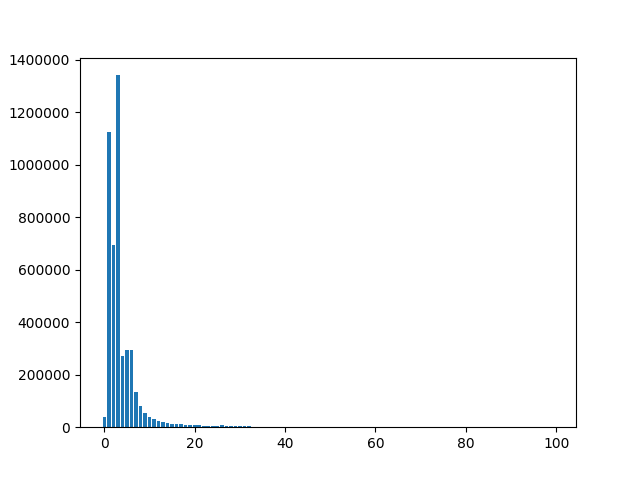

<BarContainer object of 100 artists>

In [44]:
x=np.arange(len(degree_hist[:100]))
plt.bar(x,degree_hist[:100])

In [57]:
# Extract connected components
connected_components=nx.algorithms.components.connected_components(bc_graph)
connected_components=[component for component in sorted(connected_components, key=len, reverse=True)]

In [71]:
cc_graph=nx.classes.function.induced_subgraph(bc_graph,connected_components[0])
print(nx.is_connected(cc_graph))

True


In [ ]:
# Calculate Graph Diameter
diameter=nx.algorithms.distance_measures.diameter(cc_graph)
print('Graph Diameter: {} '.format(diameter))